In [7]:
import numpy as np
import random
from ahrs.filters import EKF
from scipy.spatial.transform import Rotation as R
from ahrs.common.orientation import acc2q

import skyfield
from skyfield.api import N, Star, W, E, wgs84, load, load_file
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.almanac import find_discrete, risings_and_settings
from pytz import timezone
import datetime

from skyfield.constants import AU_KM
from skyfield.vectorlib import VectorFunction
from spktype01 import SPKType01
from jplephem.spk import SPK
import warnings
import numpy as np
import networkx as nx

from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.projections import build_stereographic_projection

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import json
import pandas as pd

import geomag

## WiFi manager
https://github.com/davesteele/comitup

In [8]:
# Read targets from DB

In [9]:
# Transform celestial coordinates into alt-az


In [10]:
# Convert alt-az to number of steps

In [11]:
# Point to a given location
# Microstep until you get there and push location updates

In [12]:
# import time
# import board
# import adafruit_bno055

# i2c = board.I2C()
# sensor = adafruit_bno055.BNO055_I2C(i2c)

# https://learn.adafruit.com/adafruit-dc-and-stepper-motor-hat-for-raspberry-pi/using-stepper-motors
# from adafruit_motorkit import MotorKit
# from adafruit_motor import stepper

In [13]:
class ArrowController(object):
    """
    """
    def __init__(self, steps_per_turn_alt=2052, steps_per_turn_az=200):
        self.alt_rad = None
        self.az_rad = None
        self.steps_per_turn_alt = steps_per_turn_alt
        self.steps_per_turn_az = steps_per_turn_az
        
        i2c = board.I2C()
        self.bno055 = adafruit_bno055.BNO055_I2C(i2c)
        
        self.motorkit = MotorKit()
        self.stepper_alt = self.motorkit.stepper1
        self.stepper_az = self.motorkit.stepper2
        
        self.style_alt = SINGLE
        self.style_az = MICROSTEP
        
    def get_alt_az(self):
        _euler_angles = self.bno055.euler
        # We believe the Euler angles are Z, Y, X, with Z up and Y
        # The order of the Euler angles is RPY. P is alt, Y is az. ???
        # Also note that this is problematic if the base is tilted
        self.alt_rad = _euler_angles[1]*np.pi/180
        self.az_rad = _euler_angles[2]*np.pi/180
        # TODO check that the numbers are sane! Sometimes this returns numbers outside of 0-360
        # TODO normalize to selected range
        # TODO correct for magnetic anomaly with 
        # https://pypi.org/project/geomag/
        # Lat in degrees
        # Lon in degrees
        # El in FEET
        #geomag.declination(dlat=45, dlon=8,h=600)
        # mag heading = real heading - decli
        return self.alt_rad, self.az_rad
        
    def slew_to_alt_az(self, _alt_rad, _az_rad):
        delta_az_rad = (_az_rad-self.az_rad)
        delta_alt_rad = (_alt_rad-self.alt_rad)
        # Normalize rotations
        while delta_alt_rad>np.pi/2:
            delta_alt_rad -= np.pi/2
        while delta_alt_rad<-np.pi/2:
            delta_alt_rad += np.pi/2
        while delta_az_rad>np.pi:
            delta_az_rad -= np.pi
        while delta_az_rad<-np.pi:
            delta_az_rad += np.pi
        
        steps_alt = (_alt_rad-self.alt_rad)*self.steps_per_turn_alt/(2*np.pi)
        steps_az = (_az_rad-self.az_rad)*self.steps_per_turn_az/(2*np.pi)
        if steps_alt>0:
            direction_alt = FORWARD
            direction_sign_alt = 1
        else:
            direction_alt = BACKWARD
            direction_sign_alt = -1
        if steps_az>0:
            direction_az = FORWARD
            direction_sign_az = 1
        else:
            direction_az = BACKWARD
            direction_sign_az = -1
            
        # SINGLE, DOUBLE, INTERLEAVE, MICROSTEP

        
        for _s in range(direction_sign_ra*steps_alt):
            # Command
            self.stepper_alt.onestep(direction=direction_alt, style=self.style_alt)
            # Update open-loop location
            self.alt_rad += direction_sign_ra*np.pi/self.steps_alt
            
        for _s in range(direction_sign_az*steps_az):
            # Command
            self.stepper_az.onestep(direction=direction_az, style=self.style_az)
            # Update open-loop location
            self.az_rad += direction_sign_az*np.pi/self.steps_az

In [14]:
# def display_celestial_object(self, celestial_object):
#     # Get observer position
#     # Get initial pose of arrow
#     # Show name on display
#     # while not stopped
#     # Get RA and dec of celestial object
#     # Command controller.slew_to_alt_az
#     # Pulse LED appropriately
    

## Filters

In [15]:
num_samples = 1000              # Assuming sensors have 1000 samples each

acc_data = np.random.random([num_samples, 3])

gyr_data = np.random.random([num_samples, 3])

In [16]:


ekf = EKF( Dt=np.random.random())
Q = np.zeros((num_samples, 4))  # Allocate array for quaternions
Q[0] = acc2q(acc_data[0])       # First sample of tri-axial accelerometer
right_ascensions = np.zeros([num_samples,])
declinations = np.zeros([num_samples,])
rolls = np.zeros([num_samples,])
for t in range(1, num_samples):
    ekf.Dt = np.random.random()
    Q[t] = ekf.update(Q[t-1], gyr_data[t], acc_data[t])
    # Quaternion is scalar-first, https://ahrs.readthedocs.io/en/latest/filters/ekf.html
    # Scipy wants scalar last, https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html
    _rot = R.from_quat([Q[t][1], Q[t][2], Q[t][3], Q[t][0]])
    [right_ascensions[t], declinations[t], rolls[t]] =_rot.as_euler('ZXY')

In [17]:
right_ascensions

array([ 0.00000000e+00,  1.41592981e-01, -3.66796162e-01, -6.50233849e-01,
       -7.66704641e-01, -1.04353612e+00, -1.98951795e+00, -2.77648591e+00,
        2.73248637e+00,  2.73766275e+00,  2.26819024e+00,  1.75087750e+00,
        1.40863936e+00,  1.41558573e+00,  6.61796611e-01,  3.67731287e-02,
       -7.61268139e-02, -7.51744289e-01, -9.86204463e-01, -1.84047174e+00,
       -1.78144169e+00, -1.93211300e+00, -2.27342238e+00, -2.72234229e+00,
       -2.75498468e+00,  2.73432694e+00,  2.66703248e+00,  2.24969194e+00,
        1.38978233e+00,  2.18235394e-01, -7.37824123e-01, -5.36500882e-01,
       -5.59459843e-01, -1.11126316e+00, -1.48142014e+00, -1.94692165e+00,
       -2.58080893e+00, -2.90224796e+00,  2.88127066e+00,  2.85050593e+00,
        2.27920056e+00,  1.38806950e+00,  1.13610489e+00,  8.15819445e-01,
        5.63538169e-01,  5.74927580e-01,  3.45225006e-01,  2.22247493e-01,
       -6.15935219e-01, -7.61149195e-01, -8.86309440e-01, -1.02761066e+00,
       -2.00015375e+00, -

## Where are stars in the sky

https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html

https://docs.astropy.org/en/stable/coordinates/index.html

## Star catalogs

https://rhodesmill.org/pyephem/quick.html
List of PyEphem bodies:
https://oneau.wordpress.com/2010/07/04/astrometry-in-python-with-pyephem/#body

Or look into the new SkyField (with native SPICE support!)

https://rhodesmill.org/skyfield/

Mission data:
https://naif.jpl.nasa.gov/pub/naif/

## Earth objects

## Satellites with TLEs

https://rhodesmill.org/skyfield/earth-satellites.html

In [18]:
ts = load.timescale()
western = timezone('US/Pacific')

t0 = ts.from_datetime(western.localize(datetime.datetime.now()))
t1 = ts.from_datetime(western.localize(datetime.datetime.now()+datetime.timedelta(hours=24)))

from skyfield.api import load, wgs84

stations_url = 'http://celestrak.com/NORAD/elements/stations.txt'
stations = load.tle_file(stations_url, filename="data/Celestrak_stations.txt")

print('Loaded', len(stations), 'satellites')

# TODO if epoch is too old, try to reload

by_name_stations = {sat.name: sat for sat in stations}
satellite = by_name_stations['ISS (ZARYA)']
jpl_relative = wgs84.latlon(34.1992588*N,118.1753085*W, elevation_m=200)
planets = load('de440.bsp')

t_events, events = satellite.find_events(jpl_relative, t0, t1, altitude_degrees=30.0)
if len(events):
    print("Events found!")
    for ti, event in zip(t_events, events):
        name = ('rise above 30°', 'culminate', 'set below 30°')[event]
        
        sunlit_str = "(satellite not sunlit, "
        obs_sunlit_str = "observer not sunlit)"
        sunlit = satellite.at(ti).is_sunlit(planets)
        obs_sunlit = jpl_relative.at(ti).is_sunlit(planets)
        if sunlit:
            sunlit_str = "(satellite sunlit, "
        if obs_sunlit:
            obs_sunlit_str = "observer sunlit)"
            
        print(ti.utc_strftime('%Y %b %d %H:%M:%S'), "UTC", name, sunlit_str, obs_sunlit_str)

[#################################] 100% Celestrak_stations.txt


Loaded 68 satellites


[#################################] 100% de440.bsp


Events found!
2021 Nov 02 15:26:59 UTC rise above 30° (satellite sunlit,  observer not sunlit)
2021 Nov 02 15:27:39 UTC culminate (satellite sunlit,  observer not sunlit)
2021 Nov 02 15:28:18 UTC set below 30° (satellite sunlit,  observer not sunlit)
2021 Nov 03 08:06:46 UTC rise above 30° (satellite not sunlit,  observer not sunlit)
2021 Nov 03 08:08:18 UTC culminate (satellite not sunlit,  observer not sunlit)
2021 Nov 03 08:09:50 UTC set below 30° (satellite not sunlit,  observer not sunlit)


## Satellites with no TLEs from NAIF/SPICE

[#################################] 100% CometEls.txt
[#################################] 100% hip_main.dat
[#################################] 100% constellationship.fab


Text(0.5, 1.0, 'Comet NEOWISE 2020 July 17 through 2020 July 26')

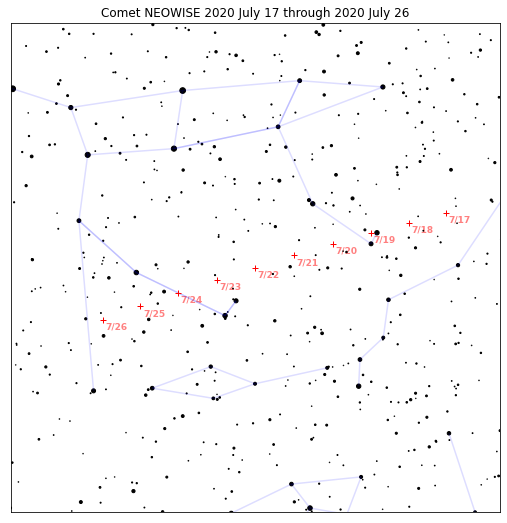

In [19]:


# The comet is plotted on several dates `t_comet`.  But the stars only
# need to be drawn once, so we take the middle comet date as the single
# time `t` we use for everything else.

ts = load.timescale()
t_comet = ts.utc(2020, 7, range(17, 27))
t = t_comet[len(t_comet) // 2]  # middle date

# An ephemeris from the JPL provides Sun and Earth positions.

eph = load('de440.bsp')
sun = eph['sun']
earth = eph['earth']

# The Minor Planet Center data file provides the comet orbit.

with load.open(mpc.COMET_URL, filename='data/CometEls.txt') as f:
    comets = mpc.load_comets_dataframe(f)

comets = (comets.sort_values('reference')
          .groupby('designation', as_index=False).last()
          .set_index('designation', drop=False))

row = comets.loc['C/2020 F3 (NEOWISE)']
comet = sun + mpc.comet_orbit(row, ts, GM_SUN)

# The Hipparcos mission provides our star catalog.

with load.open(hipparcos.URL, filename="data/hip_main.dat") as f:
    stars = hipparcos.load_dataframe(f)

# And the constellation outlines come from Stellarium.  We make a list
# of the stars at which each edge stars, and the star at which each edge
# ends.

url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
       '/skycultures/western_SnT/constellationship.fab')

with load.open(url, filename='data/constellationship.fab') as f:
    constellations = stellarium.parse_constellations(f)

edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

# We will center the chart on the comet's middle position.

center = earth.at(t).observe(comet)
projection = build_stereographic_projection(center)
field_of_view_degrees = 45.0
limiting_magnitude = 7.0

# Now that we have constructed our projection, compute the x and y
# coordinates that each star and the comet will have on the plot.

star_positions = earth.at(t).observe(Star.from_dataframe(stars))
stars['x'], stars['y'] = projection(star_positions)

comet_x, comet_y = projection(earth.at(t_comet).observe(comet))

# Create a True/False mask marking the stars bright enough to be
# included in our plot.  And go ahead and compute how large their
# markers will be on the plot.

bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
marker_size = (0.5 + limiting_magnitude - magnitude) ** 2.0

# The constellation lines will each begin at the x,y of one star and end
# at the x,y of another.  We have to "rollaxis" the resulting coordinate
# array into the shape that matplotlib expects.

xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

# Time to build the figure!

fig, ax = plt.subplots(figsize=[9, 9])

# Draw the constellation lines.

ax.add_collection(LineCollection(lines_xy, colors='#00f2'))

# Draw the stars.

ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
           s=marker_size, color='k')

# Draw the comet positions, and label them with dates.

comet_color = '#f00'
offset = 0.002

ax.plot(comet_x, comet_y, '+', c=comet_color, zorder=3)

for xi, yi, tstr in zip(comet_x, comet_y, t_comet.utc_strftime('%m/%d')):
    tstr = tstr.lstrip('0')
    text = ax.text(xi + offset, yi - offset, tstr, color=comet_color,
                   ha='left', va='top', fontsize=9, weight='bold', zorder=-1)
    text.set_alpha(0.5)

# Finally, title the plot and set some final parameters.

angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle) / (1.0 - np.cos(angle))

ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect(1.0)
ax.set_title('Comet NEOWISE {} through {}'.format(
    t_comet[0].utc_strftime('%Y %B %d'),
    t_comet[-1].utc_strftime('%Y %B %d'),
))

# Save.


In [20]:
stellarium_messier_URL = 'https://raw.githubusercontent.com/Stellarium/stellarium/master/nebulae/default/catalog.txt'

In [21]:
from skyfield.constants import T0

# via https://github.com/skyfielders/python-skyfield/discussions/634

_COLUMN_NAMES = (
    'DSOID', 'RAdeg', 'DEdeg', 'Bmag', 'Vmag',
    'OType', 'MType', 'MajRarcmin', 'MinRarcmin', 'OAdegrees', 'RS', 'RSerror',
    'Plx', 'Plxerror', 'NRSdist', 'NRSdisterror', 'NGC', 'IC', 'M', 'C', 'B',
    'Sh2', 'VdB', 'RCW', 'LDN', 'LBN', 'Cr', 'Mel', 'PGC', 'UGC', 'Ced', 'Arp', 'VV', 'PK', 'PN',
    'SNR', 'ACO', 'HCG', 'ESO', 'VdBH', 'DWB', 'Tr', 'St', 'Ru', 'VdB-Ha',
)


def load_stellarium_messier_dso_dataframe(fobj):
    """Given an open file for `catalog.txt`, return a parsed dataframe.

    If your copy of ``catalog.txt`` has already been unzipped, pass the
    optional argument ``compression=None``.

    """
    try:
        from pandas import read_csv, set_option
    except ImportError:
        raise ImportError("NO PANDAS NO CANDO")

    fobj.seek(0)
    magic = fobj.read(2)
    compression = 'gzip' if (magic == b'\x1f\x8b') else None
    fobj.seek(0)

    df = read_csv(
        fobj, sep='	', names=_COLUMN_NAMES, compression=compression,
        comment='#',
        usecols=['DSOID', 'RAdeg', 'DEdeg', 'Bmag', 'Vmag', 'M'],
        na_values=[''],
    )
    df.columns = (
        'dso_id', 'ra_degrees', 'dec_degrees', 'magnitudeB', 'magnitude',
        'messier_id',
    )
    df = df.assign(
        ra_hours = df['ra_degrees'] / 15.0,
        epoch_year = 2000.0,
    )
    df.loc[df['messier_id'] != 0.0, 'label'] = 'M' + df['messier_id'].astype(str)
    df = df[~df.messier_id.eq(0.0)]
    return df.set_index('dso_id')




In [22]:
d3cel_messier_URL = 'https://raw.githubusercontent.com/ofrohn/d3-celestial/master/data/messier.json'

In [23]:


def load_d3_celestial_messier_dataframe(fobj):
    """Given an open file for a JSON de-celestial Messier catalog, return a parsed dataframe.
    """
    try:
        from pandas import read_json, set_option
    except ImportError:
        raise ImportError("NO PANDAS NO CANDO")

    fobj.seek(0)
    magic = fobj.read(2)
    compression = 'gzip' if (magic == b'\x1f\x8b') else None
    fobj.seek(0)

    _catalog = json.load(fobj)
        
    df = pd.json_normalize(_catalog, record_path=['features'])
    
    df['dso_id'] = df['id']
    df['ra_degrees'] = df['geometry.coordinates'].map(lambda x: x[0])
    df['dec_degrees'] = df['geometry.coordinates'].map(lambda x: x[1])
    df['messier_id'] = df['id'][1:]
    df['magnitude'] = df['properties.mag']
    df['named'] = df.apply(lambda x: len(x['properties.alt'])>0, axis=1)
    df['dso_name'] = df.apply(lambda x: x['properties.alt'] + " (" + x['properties.name'] +")" if x['properties.alt'] else x['properties.name'], axis=1)
    df['label'] = df['dso_name']
    
    df = df.assign(
        ra_hours = df['ra_degrees'] / 15.0,
        epoch_year = 2000.0,
    )

    return df #.set_index('dso_id')

In [24]:
with load.open(d3cel_messier_URL, filename="data/d3cel_Messier.json") as f:
    mlist = load_d3_celestial_messier_dataframe(f)

[#################################] 100% d3cel_Messier.json


[#################################] 100% Stellarium_Messier.txt


Andromeda (M31) is visible!
M32 is visible!
Triangulum (M33) is visible!
M34 is visible!
M52 is visible!
Little Dumbbell Nebula (M76) is visible!
M103 is visible!
M110 is visible!


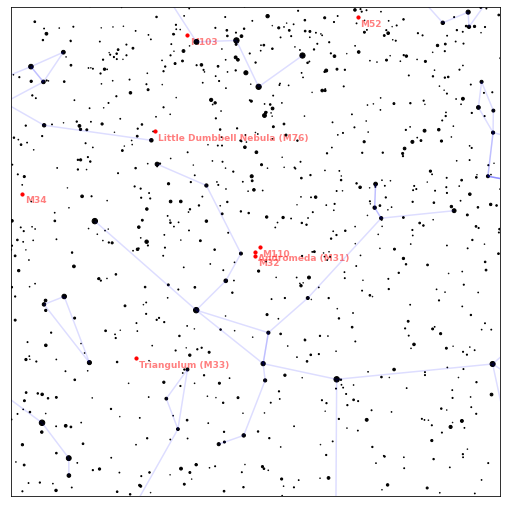

In [25]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from skyfield.api import Star, load
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection

# The comet is plotted on several dates `t_comet`.  But the stars only
# need to be drawn once, so we take the middle comet date as the single
# time `t` we use for everything else.

ts = load.timescale()
t = ts.from_datetime(western.localize(datetime.datetime.now()))

# An ephemeris from the JPL provides Sun and Earth positions.

eph = load('de440.bsp')
sun = eph['sun']
earth = eph['earth']

# The Hipparcos mission provides our star catalog.

with load.open(hipparcos.URL,filename='data/hip_main.dat') as f:
    stars = hipparcos.load_dataframe(f)
    
# Here are the DSOs
with load.open(stellarium_messier_URL, filename="data/Stellarium_Messier.txt") as f:
    dsolist = load_stellarium_messier_dso_dataframe(f)
    
with load.open(d3cel_messier_URL, filename="data/d3cel_Messier.json") as f:
    dsolist = load_d3_celestial_messier_dataframe(f)

# And the constellation outlines come from Stellarium.  We make a list
# of the stars at which each edge stars, and the star at which each edge
# ends.

url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
       '/skycultures/western_SnT/constellationship.fab')

with load.open(url, filename='data/constellationship.fab') as f:
    constellations = stellarium.parse_constellations(f)

edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

# We will center the chart on the comet's middle position.

M31 = Star.from_dataframe(dsolist[dsolist['id']=='M31'])

# M81 = Star.from_dataframe(dsolist[dsolist['id']=='M81'])


center = earth.at(t).observe(M31)
projection = build_stereographic_projection(center)
field_of_view_degrees = 45.0
limiting_magnitude = 7.0

# Now that we have constructed our projection, compute the x and y
# coordinates that each star and the comet will have on the plot.

star_positions = earth.at(t).observe(Star.from_dataframe(stars))
stars['x'], stars['y'] = projection(star_positions)

# Create a True/False mask marking the stars bright enough to be
# included in our plot.  And go ahead and compute how large their
# markers will be on the plot.

bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
marker_size = (0.5 + limiting_magnitude - magnitude) ** 2.0

# The constellation lines will each begin at the x,y of one star and end
# at the x,y of another.  We have to "rollaxis" the resulting coordinate
# array into the shape that matplotlib expects.

xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

# Time to build the figure!

fig, ax = plt.subplots(figsize=[9, 9])

# Draw the constellation lines.

ax.add_collection(LineCollection(lines_xy, colors='#00f2'))

# Draw the stars.

ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
           s=marker_size, color='k')

# Draw the DSOs

dso_positions = earth.at(t).observe(Star.from_dataframe(dsolist))
dsolist['x'], dsolist['y'] = projection(dso_positions)

ax.scatter(dsolist['x'], dsolist['y'],
           s=10, color='r')

offset = 0.002

angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle) / (1.0 - np.cos(angle))

for xi, yi, tstr in zip(dsolist['x'], dsolist['y'], dsolist['label']):
    if xi>-limit and xi<limit and yi>-limit and yi<limit:
        print(f"{tstr} is visible!")
        text = ax.text(xi+offset, yi-offset, tstr, color='r',
                       ha='left', va='top', fontsize=9, weight='bold', zorder=-1)
        text.set_alpha(0.5)

# Finally, title the plot and set some final parameters.



ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect(1.0)

# Save.


# CATALOGS

In [29]:
class Observable(object):
    def __init__(
        self,
        name,
        data,
        weight:float=1.,
        color:list=[1., 1., 1.],
        check_visible:bool=True,
    ):
        self.name = name
        self.data = data
        self.weight = weight
        self.color = color
        self.check_visible = check_visible
    def observe_topocentric(
        self,
        observer_lon_rad:
        float,
        observer_lat_rad: float,
        observer_h_m: float, 
        observing_time: datetime.datetime,
    ):
        raise NotImplemented
    def __str__(self):
        return("Observable: {}".format(self.name))
    def __repr__(self):
        return("Observable: {}\n{}".format(self.name,self.data))

In [30]:
class ObservableTerrestrialLocation(Observable):
    def __init__(
        self,
        name: str,
        data: dict,
        weight:float=1.,
        color:list=[1., 1., 1.],
        check_visible:bool=False
    ):
        self.name = name
        self.data = data
        self.weight = weight
        self.color = color
        self.check_visible = check_visible
        self.location_relative = wgs84.latlon(
            data["lat_deg_N"]*N,
            data["lon_deg_E"]*E,
            elevation_m=data["alt_m"]
        )
        
    def observe_topocentric(
        self,
        observer_lon_E_deg: float,
        observer_lat_N_deg: float,
        observer_h_m: float, 
        observing_time: datetime,
    ):
        ts = load.timescale()
        t = ts.from_datetime(observing_time)
        
        observer_relative = wgs84.latlon(
            latitude_degrees=observer_lat_N_deg*N,
            longitude_degrees=observer_lon_E_deg*E,
            elevation_m=observer_h_m
        )
        
        location_relative = self.location_relative - observer_relative
        loc_topocentric = location_relative.at(t)
        alt, az, distance = loc_topocentric.altaz()
        
        return alt.radians, az.radians, distance
    
    def __str__(self):
        return("Observable terrestrial location: {}".format(self.name))
    def __repr__(self):
        return("Observable: {}\n{}".format(self.name,self.data))

In [32]:
class ObservableSkyObject(Observable):
    def __init__(
        self,
        name: str,
        data: skyfield.jpllib.ChebyshevPosition,
        earth=None,
        weight:float=1.,
        color:list=[1., 1., 1.],
        check_visible:bool=True,
    ):
        self.name = name
        self.body = data
        self.weight = weight
        self.color = color
        self.check_visible = check_visible
        if earth is None:
            self.planets = load('de440.bsp')
            self.earth = self.planets['earth']
        else:
            self.earth = earth
        
    def observe_topocentric(
        self,
        observer_lon_E_deg: float,
        observer_lat_N_deg: float,
        observer_h_m: float, 
        observing_time: datetime,
    ):
        ts = load.timescale()
        t = ts.from_datetime(observing_time)
        
        observer = self.earth+wgs84.latlon(
            observer_lat_N_deg*N,
            observer_lon_E_deg*E,
            elevation_m=observer_h_m
        )
        
        body_astrometric = observer.at(t).observe(self.body)

        alt, az, distance = body_astrometric.apparent().altaz()
        
        return alt.radians, az.radians, distance
    
    def __str__(self):
        return("Observable sky object: {}".format(self.name))
    def __repr__(self):
        return("Observable: {}\n{}".format(self.name,self.body))

In [33]:
class ObservableSatellite(Observable):
    def __init__(
        self,
        name: str,
        data: skyfield.sgp4lib.EarthSatellite,
        weight:float=1.,
        color:list=[1., 1., 1.],
        check_visible:bool=True,
    ):
        self.name = name
        self.satellite = data
        self.weight = weight
        self.color = color
        self.check_visible = check_visible
    def observe_topocentric(
        self,
        observer_lon_E_deg: float,
        observer_lat_N_deg: float,
        observer_h_m: float, 
        observing_time: datetime,
    ):
        ts = load.timescale()
        t = ts.from_datetime(observing_time)
        
        observer_relative = wgs84.latlon(
            latitude_degrees=observer_lat_N_deg*N,
            longitude_degrees=observer_lon_E_deg*E,
            elevation_m=observer_h_m
        )
        
        sat_relative = self.satellite - observer_relative
        sat_topocentric = sat_relative.at(t)
        alt, az, distance = sat_topocentric.altaz()
        
        return alt.radians, az.radians, distance
    
    def __str__(self):
        return("Observable satellite: {}".format(self.name))
    def __repr__(self):
        return("Observable: {}\n{}".format(self.name,self.satellite))

In [34]:
import spiceypy as spice
from typing import List
import datetime
import os
NAIF_PATH = os.getenv("NAIF_PATH")

class RawSPICEObject(VectorFunction):
    def __init__(self, kernel_list, target):
        self.kernel_list = kernel_list
        for kernel in kernel_list:
            spice.furnsh(kernel)
        self.center = 0
        self.target = target

    def _at(self, t):
        time_et = spice.datetime2et(t.utc_datetime())
        state, _ = spice.spkezr(self.target, [time_et,], 'J2000', 'NONE', '0' )
        r = state[0][:3]
        v = state[0][3:]
        return r / AU_KM, v / AU_KM, None, None

ModuleNotFoundError: No module named 'spiceypy'

In [35]:
from skyfield.vectorlib import VectorFunction
from skyfield.constants import AU_KM
from skyfield.vectorlib import VectorFunction
from skyfield.api import N, Star, W, wgs84, load, load_file
import warnings
import networkx as nx
import numpy as np



from spktype01 import SPKType01
from jplephem.spk import SPK


class Type01Object(VectorFunction):
    def __init__(self, kernel_type1, target, kernel_type2=None):
        self.kernel = kernel_type1
        self.kernel_type2 = kernel_type2
        self.center = 0
        self.target = target

    def _at(self, t):
        k = self.kernel
        k2 = self.kernel_type2
        try:
            r, v = k.compute_type01(0, self.target, t.whole, t.tdb_fraction)
        except ValueError as ve:
            if k2 is None:
                raise(ve)
            warnings.warn("No segment from SSB 0 to {}, trying to find a transform".format(self.target))
            # Let's build a graph of dependencies
            # First, is there a segment with the origin and one with the destination?
            found_center = False
            found_target = False
            for segment in k.segments:
                if segment.center == 0:
                    found_center = True
                if segment.target == self.target:
                    found_target = True
                if (found_center and found_target):
                    break
            if not (found_center and found_target):
                raise ValueError("No transform from center SSB 0 to target {}: either center or target not in kernel".format(self.target))
            # Now we need to find a path from center to target.
            G = nx.DiGraph()
            for segment in k.segments:
                G.add_edge(segment.center, segment.target)
            transform_path = nx.shortest_path(G,0,self.target)
            if not len(transform_path):
                raise ValueError("No transform from center SSB 0 to target {}: center and target not connected".format(self.target))
            for _node_ix, _node in enumerate(transform_path[:-1]):
                _next_node = transform_path[_node_ix+1]
#                 print(k, _node, _next_node)
                # Now, some segments may not be Type 1...
                r = np.zeros([3,])
                v = np.zeros([3,])
                try:
                    _dr, _dv = k.compute_type01(_node, _next_node, t.whole, t.tdb_fraction)
                except ValueError:
                    _dr, _dv = k2[_node, _next_node].compute_and_differentiate(t.whole+t.tdb_fraction)
                r += _dr
                v += _dv
            
        return r / AU_KM, v / AU_KM, None, None

## People: Sele, David, Flavio, Fede, Marzia

In [36]:
# Need: name, lat, lon, alt

mellyn = [
    {
        "name": "Sele",
        "lon_deg_E": 0.3388028,
         "lat_deg_N": 46.5786531,
         "alt_m": 108,
    },
    {
        "name": "David",
        "lon_deg_E": -99.133333,
        "lat_deg_N": 19.433333,
        "alt_m": 2240,
    },
    {
        "name": "Flavio",
        "lon_deg_E": 2.2888966, 
        "lat_deg_N": 48.8457733,
        "alt_m": 39,
    },
    {
        "name": "FedeF",
        "lon_deg_E": 8.8088578,
        "lat_deg_N": 45.658723,
        "alt_m": 244,
    },
    {
        "name": "Marzia",
        "lon_deg_E": 8.795686,
        "lat_deg_N": 45.6462893,
        "alt_m": 238,
    },
    {
        "name": "Rinaldini",
        "lon_deg_E": 8.7753137,
        "lat_deg_N": 45.6494564,
        "alt_m": 255,
    },
    {
        "name": "Inge",
        "lon_deg_E": -118.138686,
        "lat_deg_N": 34.1376481,
        "alt_m": 204,
    },
]

In [37]:
ObservableMellyn = [ObservableTerrestrialLocation(name=mellon['name'], data=mellon) for mellon in mellyn]

In [38]:
western = timezone('US/Pacific')
t = western.localize(datetime.datetime.now())

for mellon_obs in ObservableMellyn:
    print(mellon_obs.observe_topocentric(
        observer_lon_E_deg=mellyn[4]['lon_deg_E'],
        observer_lat_N_deg=mellyn[4]['lat_deg_N'],
        observer_h_m=mellyn[4]['alt_m'],
        observing_time=t))

(-0.05197608942371302, 4.922553159522892, <Distance 4.42065e-06 au>)
(-0.7671054932294904, 5.170084888381807, <Distance 5.92754e-05 au>)
(-0.04790102442366891, 5.37894539117163, <Distance 4.05781e-06 au>)
(0.0033499947006820985, 0.6388863519334492, <Distance 1.15086e-08 au>)
(0.0, 0.0, <Distance 0.0 au>)
(0.010322953055434767, 4.930643461389053, <Distance 1.08744e-08 au>)
(-0.7582909122910781, 5.559452125396066, <Distance 5.87365e-05 au>)


## Planets: all eight and the Moon

In [39]:
planets = load('de440.bsp')
planet_names = [
    "Mercury",
    "Venus",
    "Earth",
    "Mars",
    "Jupiter",
    "Saturn",
    "Neptune",
    "Uranus",
    "Pluto"
]



In [40]:
ObservablePlanets = []

for planet_name in planet_names:
    try:
        new_planet = planets[planet_name]
    except:
        new_planet = planets[planet_name+ " barycenter"]
    ObservablePlanets.append(
        ObservableSkyObject(name=planet_name, data=new_planet, earth=earth)
    )

In [41]:
t = western.localize(datetime.datetime.now())
western = timezone('US/Pacific')

for obs_planet in ObservablePlanets:
    print(obs_planet.name)
    print(obs_planet.observe_topocentric(
        observer_lon_E_deg=mellyn[4]['lon_deg_E'],
        observer_lat_N_deg=mellyn[4]['lat_deg_N'],
        observer_h_m=mellyn[4]['alt_m'],
        observing_time=t))

Mercury
(0.6274061482378064, 3.3567445690576676, <Distance 1.18434 au>)
Venus
(0.0459664481408088, 2.347131344511848, <Distance 0.640126 au>)
Earth
(-1.5674386337957447, 0.0003240458372817398, <Distance 4.25654e-05 au>)
Mars
(0.5679420939760366, 3.215243516481646, <Distance 2.58156 au>)
Jupiter
(-0.45212230317904656, 1.4853370256231748, <Distance 4.69713 au>)
Saturn
(-0.31408153185892856, 1.7348120372131304, <Distance 9.93345 au>)
Neptune
(-0.6185822444675408, 0.9500039619623929, <Distance 29.269 au>)
Uranus
(-0.501244541247193, 6.148080609423696, <Distance 18.7398 au>)
Pluto
(-0.20284749452443393, 1.936035508641356, <Distance 34.6501 au>)


## Small bodies: named ones

### Get the data:

```wget https://www.minorplanetcenter.net/iau/MPCORB/MPCORB.DAT.gz```

### Filter by interest:

```zgrep -P "^("$(paste -sd '|' minor_planets_of_interest.txt)") " MPCORB.DAT.gz > MPCORB.excerpt.DAT```

In [43]:
from skyfield.data import mpc
with load.open('data/MPCORB.excerpt.DAT') as f:
    minor_planets = mpc.load_mpcorb_dataframe(f)

In [44]:
ObservableSmallBodies = []

for minor_planet_row in minor_planets.iterrows():
    minor_planet_name = minor_planet_row[1]['designation']
    minor_planet_loc = sun + mpc.mpcorb_orbit(minor_planet_row[1], ts, GM_SUN)

    ObservableSmallBodies.append(
        ObservableSkyObject(name=minor_planet_name, data=minor_planet_loc, earth=earth)
    )

In [45]:
western = timezone('US/Pacific')
t = western.localize(datetime.datetime.now())


for obs_planet in ObservableSmallBodies:
    print(obs_planet.name)
    print(obs_planet.observe_topocentric(
        observer_lon_E_deg=mellyn[4]['lon_deg_E'],
        observer_lat_N_deg=mellyn[4]['lat_deg_N'],
        observer_h_m=mellyn[4]['alt_m'],
        observing_time=t))

(1) Ceres
(-0.3508454405192822, 5.648180872763429, <Distance 1.86517 au>)
(2) Pallas
(-0.5777207011163573, 1.1955508049370138, <Distance 2.44791 au>)
(3) Juno
(0.2608731296562618, 2.225394169130422, <Distance 3.69086 au>)
(4) Vesta
(0.4801634651676658, 2.8171954662496996, <Distance 3.11803 au>)
(6) Hebe
(-0.27195642314884755, 1.8629381308516337, <Distance 1.97394 au>)
(7) Iris
(0.1856325716815196, 5.019552276881051, <Distance 1.44434 au>)
(8) Flora
(0.6822912694524998, 3.907703752415078, <Distance 3.03828 au>)
(9) Metis
(0.4007475007593661, 2.779022797528724, <Distance 3.60937 au>)
(15) Eunomia
(0.4762065454537131, 3.7120150103796052, <Distance 3.81703 au>)
(16) Psyche
(0.5344389573774887, 4.325363654636057, <Distance 3.44933 au>)
(18) Melpomene
(0.696855987438868, 3.494492847001463, <Distance 3.67764 au>)
(20) Massalia
(0.32767816473224726, 4.793117830395902, <Distance 1.83959 au>)
(21) Lutetia
(0.6611950651862059, 3.6207114347621587, <Distance 3.59315 au>)
(192) Nausikaa
(0.363039606

## DSOs: the named Messier objects

In [46]:
import json
import pandas as pd

def load_d3_celestial_messier_dataframe(fobj):
    """Given an open file for a JSON de-celestial Messier catalog, return a parsed dataframe.
    """
    try:
        from pandas import read_json, set_option
    except ImportError:
        raise ImportError("NO PANDAS NO CANDO")

    fobj.seek(0)
    magic = fobj.read(2)
    compression = 'gzip' if (magic == b'\x1f\x8b') else None
    fobj.seek(0)

    _catalog = json.load(fobj)
        
    df = pd.json_normalize(_catalog, record_path=['features'])
    
    df['dso_id'] = df['id']
    df['ra_degrees'] = df['geometry.coordinates'].map(lambda x: x[0])
    df['dec_degrees'] = df['geometry.coordinates'].map(lambda x: x[1])
    df['messier_id'] = df['id'][1:]
    df['magnitude'] = df['properties.mag']
    df['named'] = df.apply(lambda x: len(x['properties.alt'])>0, axis=1)
    df['dso_name'] = df.apply(lambda x: x['properties.alt'] + " (" + x['properties.name'] +")" if x['properties.alt'] else x['properties.name'], axis=1)
    df['label'] = df['dso_name']
    
    df = df.assign(
        ra_hours = df['ra_degrees'] / 15.0,
        epoch_year = 2000.0,
    )

    return df

In [47]:
d3cel_messier_URL = 'https://raw.githubusercontent.com/ofrohn/d3-celestial/master/data/messier.json'
with load.open(d3cel_messier_URL, filename="data/d3cel_Messier.json") as f:
    mlist = load_d3_celestial_messier_dataframe(f)


messiers = Star.from_dataframe(mlist)

mlist_named = mlist[mlist['named']]



In [48]:
observable_messiers = [ObservableSkyObject(
    name=messier[1]['dso_name'],
    data=Star.from_dataframe(messier[1])
) for messier in mlist_named.iterrows()
]

In [49]:
western = timezone('US/Pacific')
t = western.localize(datetime.datetime.now())


for obs_planet in observable_messiers:
    print(obs_planet.name)
    print(obs_planet.observe_topocentric(
        observer_lon_E_deg=mellyn[4]['lon_deg_E'],
        observer_lat_N_deg=mellyn[4]['lat_deg_N'],
        observer_h_m=mellyn[4]['alt_m'],
        observing_time=t))

Crab Nebula (M1)
(-0.15079546568189323, 5.485197315447059, <Distance 2.06265e+14 au>)
Butterfly Cluster (M6)
(-0.010759866057565605, 2.421714171762809, <Distance 2.06265e+14 au>)
Ptolemy´s Cluster (M7)
(-0.07639311849083769, 2.405225294336432, <Distance 2.06265e+14 au>)
Lagoon Nebula (M8)
(0.050658626542360315, 2.2693825365755966, <Distance 2.06265e+14 au>)
Wild Duck Cluster (M11)
(0.17345382582784402, 1.91458757291721, <Distance 2.06265e+14 au>)
Great Hercules Cluster (M13)
(1.0698135239208955, 1.670283280751694, <Distance 2.06265e+14 au>)
Eagle Nebula (M16)
(0.1614001878721601, 2.1078273744756424, <Distance 2.06265e+14 au>)
Omega Nebula (M17)
(0.12322031992597293, 2.127214047308779, <Distance 2.06265e+14 au>)
Trifid Nebula (M20)
(0.07257174974608012, 2.259460734254959, <Distance 2.06265e+14 au>)
Milky Way patch (M24)
(0.10144654301749, 2.164888289032106, <Distance 2.06265e+14 au>)
Dumbbell Nebula (M27)
(0.328132378883711, 1.3316794558949963, <Distance 2.06265e+14 au>)
Andromeda (M31)

MemoryError: 

## Missions: all active JPL missions

- Voyagers
- Curiosity/Percy/Ginny/InSight
- Juno
- BepiColombo
- Parker
- Psyche

In [50]:
# From https://rhodesmill.org/skyfield/planets.html

# JPL kernels: https://naif.jpl.nasa.gov/pub/naif/
# ESA kernels: https://repos.cosmos.esa.int/socci/projects/SPICE_KERNELS

```cat kernels.txt | xargs wget```

In [52]:

planets = load('de440.bsp')
earth = planets['earth']
jpl = earth+wgs84.latlon(34.1992588*N,118.1753085*W, elevation_m=200)

ts = load.timescale()
t = ts.utc(2019, 1, 19)

v2_kernel_file = 'data/Voyager_2.m05016u.merged.bsp'
# v2_kernel_file = 'voyager_2.ST+1992_m05208u.merged.bsp'
voyager_2_kernel_type1 = SPKType01.open(v2_kernel_file)
voyager_2_kernel_type2 = SPK.open(v2_kernel_file)
voyager_2 = Type01Object(voyager_2_kernel_type1, -32, voyager_2_kernel_type2)
    
v2_astrometric = jpl.at(t).observe(voyager_2)

alt, az, d = v2_astrometric.apparent().altaz()

print(alt, az, d)

MemoryError: 

In [53]:
v1_kernel_file = 'data/Voyager_1.a54206u_V0.2_merged.bsp'
# v1_kernel_file = 'data/voyager_1.ST+1991_a54418u.merged.bsp'
voyager_1_kernel_type1 = SPKType01.open(v1_kernel_file)
voyager_1_kernel_type2 = SPK.open(v1_kernel_file)
voyager_1 = Type01Object(voyager_1_kernel_type1, -31, voyager_1_kernel_type2)

v2_kernel_file = 'data/Voyager_2.m05016u.merged.bsp'
# v2_kernel_file = 'data/voyager_2.ST+1992_m05208u.merged.bsp'

voyager_2_kernel_type1 = SPKType01.open(v2_kernel_file)
voyager_2_kernel_type2 = SPK.open(v2_kernel_file)
voyager_2 = Type01Object(voyager_2_kernel_type1, -32, voyager_2_kernel_type2)

In [54]:


# so, the SPKs for Juno are only in the past. https://naif.jpl.nasa.gov/pub/naif/pds/data/jno-j_e_ss-spice-6-v1.0/jnosp_1000/data/spk/spkinfo.txt
# But Juno is close enough to Jupiter for the purposes of this project
juno = planets['jupiter barycenter']

# Likewise for our Mars probes
curiosity = planets['mars barycenter']
perseverance = planets['mars barycenter']
ingenuity = planets['mars barycenter']
insight = planets['mars barycenter']
odyssey = planets['mars barycenter']

# BepiColombo

# Rosetta
# rosetta = Type01Object(rosetta_kernel_type1, -226, rosetta_kernel_type2)

In [55]:
PSPkernels = [
    'de440.bsp',
    'de440.bsp',
    'data/spp_nom_20180812_20250831_v038_RO5.bsp',
    os.path.join(NAIF_PATH,'naif','generic_kernels','lsk','naif0012.tls'),
    os.path.join(NAIF_PATH,'naif','generic_kernels','pck','pck00010.tpc'),
# 'data/ESA/rosetta/kernels/spk/ROS_ORBITER_EXTENSION_V2.BSP')
]
PSPtarget = "-96"

PSP = RawSPICEObject(PSPkernels, PSPtarget)

NameError: name 'os' is not defined

In [ ]:
t = ts.from_datetime(western.localize(datetime.datetime.now()))

PSP._at(t)
PSP_astrometric = jpl.at(t).observe(PSP)

alt, az, d = PSP_astrometric.apparent().altaz()
print(alt,az,d)

In [ ]:
import glob
bepicolombo_kernels = glob.glob('data/ESA/bepicolombo/kernels/spk/*.bsp')
bepi = RawSPICEObject(bepicolombo_kernels,"-121")

In [ ]:
bepi._at(t)
bepi_astrometric = jpl.at(t).observe(bepi)

alt, az, d = bepi_astrometric.apparent().altaz()
print(alt,az,d)

In [ ]:
# rosetta_kernels = glob.glob('data/ESA/rosetta/kernels/spk/*.BSP')
# rosetta = RawSPICEObject(rosetta_kernels,"-226")


In [ ]:
# from pytz import timezone
# western = timezone('US/Pacific')

# t = ts.from_datetime(western.localize(datetime.datetime.now()-datetime.timedelta(days=6*365)))

# rosetta._at(t)
# rosetta_astrometric = jpl.at(t).observe(rosetta)

# alt, az, d = rosetta_astrometric.apparent().altaz()
# print(alt,az,d)

In [ ]:
vgr_kernels = glob.glob('data/VGR/*.bsp')
vgr_kernels.append('de440.bsp')
vgr_kernels.append(os.path.join(NAIF_PATH,'naif','generic_kernels','lsk','naif0012.tls'))
vgr_kernels.append(os.path.join(NAIF_PATH,'naif','generic_kernels','pck','pck00010.tpc'))

vgr1 = RawSPICEObject(vgr_kernels,"-31")
vgr2 = RawSPICEObject(vgr_kernels,"-32")

In [ ]:
t = ts.from_datetime(western.localize(datetime.datetime.now()))

vgr1._at(t)
vgr1_astrometric = jpl.at(t).observe(vgr1)

alt, az, d = vgr1_astrometric.apparent().altaz()
print(alt,az,d)

vgr2._at(t)
vgr2_astrometric = jpl.at(t).observe(vgr2)

alt, az, d = vgr2_astrometric.apparent().altaz()
print(alt,az,d)

In [ ]:
# v2_astrometric = jpl.at(t).observe(voyager_2)

# alt, az, d = v2_astrometric.apparent().altaz()

# print(alt, az, d)

In [ ]:
# spice.kclear()

In [ ]:
missions = {
    "Voyager 1": vgr1,
    "Voyager 2": vgr2,
    "Juno": juno,
    "Curiosity": curiosity,
    "Perseverance": perseverance,
    "Ingenuity": ingenuity,
    "InSight": insight,
    "Mars Odyssey": odyssey,
    "Bepi Colombo": bepi,
    "Parker Solar Probe": PSP
}

In [56]:
missions_nopyspice = {
    "Voyager 1": voyager_1,
    "Voyager 2": voyager_2,
    "Juno": juno,
    "Curiosity": curiosity,
    "Perseverance": perseverance,
    "Ingenuity": ingenuity,
    "InSight": insight,
    "Mars Odyssey": odyssey,
#     "Bepi Colombo": bepi,
#     "Parker Solar Probe": PSP
}

In [57]:
ObservableMissions = [ObservableSkyObject(name=key, data=val) for key, val in missions.items()]

NameError: name 'missions' is not defined

In [58]:
ObservableMissions_nospice = [ObservableSkyObject(name=key, data=val) for key, val in missions_nopyspice.items()]

In [59]:
western = timezone('US/Pacific')
t = western.localize(datetime.datetime.now())

for ObservableMission in ObservableMissions:
    print(ObservableMission.name)
    print(ObservableMission.observe_topocentric(
        observer_lon_E_deg=-118.,
        observer_lat_N_deg=34.,
        observer_h_m=200,
        observing_time=t))

NameError: name 'ObservableMissions' is not defined

In [61]:
western = timezone('US/Pacific')
t = western.localize(datetime.datetime.now())

for ObservableMission in ObservableMissions_nospice:
    print(ObservableMission.name)
    print(ObservableMission.observe_topocentric(
        observer_lon_E_deg=-118.,
        observer_lat_N_deg=34.,
        observer_h_m=200,
        observing_time=t))

Voyager 1


MemoryError: 

## Satellites: ISS and Hubble and Chinese space station

In [62]:
from skyfield.api import load, wgs84

stations_url = 'http://celestrak.com/NORAD/elements/stations.txt'
visual_sats_url = 'https://www.celestrak.com/NORAD/elements/visual.txt'
stations = load.tle_file(stations_url, filename="data/Celestrak_stations.txt")
visual_sats = load.tle_file(visual_sats_url, filename="data/Celestrak_visual.txt")

print('Loaded', len(stations), 'satellites and ', len(visual_sats), ' satellites')

# TODO if epoch is too old, try to reload

by_name_stations = {sat.name: sat for sat in stations}
by_name_visual = {sat.name: sat for sat in visual_sats}
satellites = [by_name_stations['ISS (ZARYA)'], by_name_stations['TIANHE'], by_name_visual['HST']]



print(satellites)


[#################################] 100% Celestrak_visual.txt


Loaded 68 satellites and  164  satellites
[<EarthSatellite ISS (ZARYA) catalog #25544 epoch 2021-11-01 23:23:02 UTC>, <EarthSatellite TIANHE catalog #48274 epoch 2021-11-01 18:18:28 UTC>, <EarthSatellite HST catalog #20580 epoch 2021-11-01 05:29:12 UTC>]


In [63]:
ObservableSats = []
for satellite in satellites:
    ObservableSats.append(ObservableSatellite(name=satellite.name, data=satellite))

In [64]:
western = timezone('US/Pacific')
t = western.localize(datetime.datetime.now())


for ObservableSat in ObservableSats:
    print(ObservableSat.name)
    print(ObservableSat.observe_topocentric(
        observer_lon_E_deg=8.,
        observer_lat_N_deg=45.,
        observer_h_m=200,
        observing_time=t))

ISS (ZARYA)
(-0.27412814618486553, 3.76614316983639, <Distance 3.09461e-05 au>)
TIANHE
(-0.1411950890468054, 4.051514924377763, <Distance 2.21687e-05 au>)
HST
(-0.44937905988918514, 3.3403710871728594, <Distance 4.41112e-05 au>)


In [65]:
alt, az, _ = ObservableSat.observe_topocentric(
        observer_lon_E_deg=8.,
        observer_lat_N_deg=45.,
        observer_h_m=200,
        observing_time=t)

## All together

In [67]:
# Observables = ObservableSats+ObservableMissions+ObservablePlanets+ObservableSmallBodies+ObservableMellyn
Observables = ObservableSats+ObservablePlanets+ObservableSmallBodies+ObservableMellyn

In [68]:
display_time_minutes = 5
schedule = [
    {
        'start_time': datetime.datetime(
            year=datetime.datetime.now().year,
            month=datetime.datetime.now().month,
            day=datetime.datetime.now().day,
            hour=datetime.datetime.now().hour,
            minute=int(np.floor(datetime.datetime.now().minute/display_time_minutes))*display_time_minutes, # Start at the next 5-minute mark
            second=0
            )+datetime.timedelta(minutes=obs_ix*display_time_minutes),
        'end_time': datetime.datetime(
            year=datetime.datetime.now().year,
            month=datetime.datetime.now().month,
            day=datetime.datetime.now().day,
            hour=datetime.datetime.now().hour,
            minute=int(np.floor(datetime.datetime.now().minute/display_time_minutes))*display_time_minutes, # Start at the next 5-minute mark
            second=0
            )+datetime.timedelta(minutes=(obs_ix+1)*display_time_minutes),
        'observable': observable,
        'color_rgb': (1., 1., 1),
    }
    for obs_ix, observable in enumerate(Observables)
]

In [69]:
schedule

[{'start_time': datetime.datetime(2021, 11, 2, 3, 55),
  'end_time': datetime.datetime(2021, 11, 2, 4, 0),
  'observable': Observable: ISS (ZARYA)
  ISS (ZARYA) catalog #25544 epoch 2021-11-01 23:23:02 UTC,
  'color_rgb': (1.0, 1.0, 1)},
 {'start_time': datetime.datetime(2021, 11, 2, 4, 0),
  'end_time': datetime.datetime(2021, 11, 2, 4, 5),
  'observable': Observable: TIANHE
  TIANHE catalog #48274 epoch 2021-11-01 18:18:28 UTC,
  'color_rgb': (1.0, 1.0, 1)},
 {'start_time': datetime.datetime(2021, 11, 2, 4, 5),
  'end_time': datetime.datetime(2021, 11, 2, 4, 10),
  'observable': Observable: HST
  HST catalog #20580 epoch 2021-11-01 05:29:12 UTC,
  'color_rgb': (1.0, 1.0, 1)},
 {'start_time': datetime.datetime(2021, 11, 2, 4, 10),
  'end_time': datetime.datetime(2021, 11, 2, 4, 15),
  'observable': Observable: Mercury
  Sum of 2 vectors:
   'de440.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 1 MERCURY BARYCENTER
   'de440.bsp' segment 1 MERCURY BARYCENTER -> 199 MERCURY,
  'color_rgb': (

Maintain the observables list:
- Remove entries with an end time prior to the current time
- If there aren't enough entries to the desired end time, append entries randomly* picked

* Optionally checking for visibility, and optionally with a variable weight.

For visible satellite passes:
- Check if there will be such a pass within the window of interest
- If there is, find the entries overlapping with the pass.
- If an entry overlaps entirely, remove it.
- If an entry ends in the pass, truncate its exit.
- If an entry starts in the pass, truncate its intro.

## Colors!

In [ ]:
import matplotlib.colors as mcolors

In [ ]:
[mcolors.to_rgb(color) for color in mcolors.TABLEAU_COLORS]

In [ ]:
mcolors.XKCD_COLORS

In [ ]:
from matplotlib.patches import Rectangle
def plot_colortable(colors, title, sort_colors=True, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

In [ ]:
_ = plot_colortable(mcolors.BASE_COLORS, "Base Colors",
                sort_colors=False, emptycols=1)


In [ ]:
_ = plot_colortable(mcolors.TABLEAU_COLORS, "Tableau Palette",
                sort_colors=False, emptycols=2)



In [ ]:
_ = plot_colortable(mcolors.CSS4_COLORS, "CSS Colors")

In [ ]:

# Optionally plot the XKCD colors (Caution: will produce large figure)
xkcd_fig = plot_colortable(mcolors.XKCD_COLORS, "XKCD Colors")

In [ ]:
# Colors: one per type of event.
# One for warnings, orange yellow.
# One for errors, neon red.
# Cool colors: 
# xkcd: pale, or css:ivory 
# xkcd: baby green
# xkcd:light periwinkle
# xkcd:pale mauve or xkcd:very light purple
# xkcd:pastel blue

In [ ]:
cool_colors = [
    "xkcd:pale",
    "xkcd:baby green",
    "xkcd:light periwinkle",
    "xkcd:pale mauve",
    "xkcd:very light purple",
    "xkcd:pastel blue"
]

for cool_color in cool_colors:
    print(mcolors.to_rgb(mcolors.XKCD_COLORS[cool_color]))

# App

In [ ]:
# controller = ArrowController(steps_per_turn_alt=2052, steps_per_turn_az=200)

In [70]:
class ObserverLLA(object):
    def __init__(self, lat_rad: float, lon_rad: float, alt_m: float=0):
        self.lat_rad = lat_rad
        self.lon_rad = lon_rad
        self.alt_m = alt_m

In [71]:
class VisibilityWindow(object):
    def __init__(
        self,
        min_alt_rad: float=-np.pi/2.,
        max_alt_rad: float= np.pi/2.,
        min_az_rad:  float= 0.,
        max_az_rad:  float= 2*np.pi
    ):
        self.min_alt_rad = min_alt_rad
        self.max_alt_rad = max_alt_rad
        self.min_az_rad = min_az_rad
        self.max_az_rad = max_az_rad
        
    def is_visible(
        self,
        observable: Observable,
        observer=ObserverLLA,
        time:datetime.datetime = datetime.datetime.now(),
        verbose:bool=False,
    ):
        _alt_rad, _az_rad, _ = observable.observe_topocentric(
        observer_lon_E_deg=observer.lon_rad*180./np.pi,
        observer_lat_N_deg=observer.lat_rad*180./np.pi,
        observer_h_m=observer.alt_m,
        observing_time=t)
        if _alt_rad >= self.min_alt_rad and _alt_rad <= self.max_alt_rad and _az_rad>=self.min_az_rad and _az_rad <=self.max_az_rad:
#             if verbose:
#                 print("{} is visible: alt {}, az {}".format(observable, _alt_rad, _az_rad))
            return True
        else:
            if verbose:
                print("{} is not visible: alt {}, az {}".format(observable, _alt_rad, _az_rad))
            return False
    
    


In [73]:
class CelestialCompass(object):
    def __init__(
        self,
        controller: ArrowController,
        observer: ObserverLLA,
        observables: list,
        time_on_target_s: float=300,
        target_list_length_s: float=7200,
        check_visible: bool = False,
        visibility_window: VisibilityWindow=VisibilityWindow(),        
    ):
        self.controller = controller
        self.observer = observer
        self.observables = observables
        self.time_on_target_s = time_on_target_s
        self.target_list_length_s = target_list_length_s
        self.schedule = []
        self.check_visible = check_visible
        self.visibility_window = visibility_window
        self.update_schedule()
        
    def update_schedule(self):
        current_time = datetime.datetime.now()
        attempts_to_add = 0
        while ((
            len(self.schedule) == 0 or 
            self.schedule[-1]['end_time']<current_time+datetime.timedelta(seconds=self.target_list_length_s))
        and attempts_to_add<50*(self.target_list_length_s/self.time_on_target_s)):
            attempts_to_add += 1
            _observable = random.choices(
                self.observables,
                weights = [obs.weight for obs in self.observables],
                k=1)[0]
            # If this is already in the list
            if _observable.name in [_s['observable'].name for _s in self.schedule]:
                continue
            if self.check_visible and _observable.check_visible:
                _visible_start = self.visibility_window.is_visible(_observable, self.observer, schedule[-1]['end_time'])
                _visible_end = self.visibility_window.is_visible(_observable, self.observer, schedule[-1]['end_time']+datetime.timedelta(seconds=self.time_on_target_s))
                if not _visible_start or not _visible_end:
                    print(_observable, "is not visible")
                    continue
            if len(self.schedule):
                _schedule_end_time = self.schedule[-1]['end_time']
            else:
                _schedule_end_time = current_time
            self.schedule.append(
                {
                    'start_time': _schedule_end_time,
                    'end_time': _schedule_end_time+datetime.timedelta(seconds=self.time_on_target_s),
                    'observable': _observable,
                    'color_rgb': (1., 1., 1),
                }
            )
        if attempts_to_add>=50*(self.target_list_length_s/self.time_on_target_s):
            warnings.warn("Very little is visible right now!")

    
    def run(self):
        pass
            

In [76]:
observer = ObserverLLA(lat_rad=45,lon_rad=8, alt_m=200)

cc = CelestialCompass(
        controller= None,
        observer = observer,
        observables = Observables,
        time_on_target_s=300.,
        target_list_length_s=1800,
        check_visible= True,
        visibility_window=VisibilityWindow(min_alt_rad=0.),        
    )

Observable sky object: (99942) Apophis is not visible
Observable sky object: Venus is not visible
Observable sky object: (7) Iris is not visible
Observable sky object: (99942) Apophis is not visible
Observable sky object: Earth is not visible
Observable sky object: (20) Massalia is not visible
Observable satellite: ISS (ZARYA) is not visible
Observable satellite: HST is not visible
Observable sky object: (20) Massalia is not visible
Observable sky object: (192) Nausikaa is not visible
Observable sky object: (243) Ida is not visible
Observable sky object: Mars is not visible
Observable sky object: (253) Mathilde is not visible


In [77]:
cc.schedule

[{'start_time': datetime.datetime(2021, 11, 2, 4, 3, 46, 817363),
  'end_time': datetime.datetime(2021, 11, 2, 4, 8, 46, 817363),
  'observable': Observable: Rinaldini
  {'name': 'Rinaldini', 'lon_deg_E': 8.7753137, 'lat_deg_N': 45.6494564, 'alt_m': 255},
  'color_rgb': (1.0, 1.0, 1)},
 {'start_time': datetime.datetime(2021, 11, 2, 4, 8, 46, 817363),
  'end_time': datetime.datetime(2021, 11, 2, 4, 13, 46, 817363),
  'observable': Observable: (9969) Braille
  Sum of 2 vectors:
   'de440.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 10 SUN
   _KeplerOrbit 10 SUN -> str,
  'color_rgb': (1.0, 1.0, 1)},
 {'start_time': datetime.datetime(2021, 11, 2, 4, 13, 46, 817363),
  'end_time': datetime.datetime(2021, 11, 2, 4, 18, 46, 817363),
  'observable': Observable: Sele
  {'name': 'Sele', 'lon_deg_E': 0.3388028, 'lat_deg_N': 46.5786531, 'alt_m': 108},
  'color_rgb': (1.0, 1.0, 1)},
 {'start_time': datetime.datetime(2021, 11, 2, 4, 18, 46, 817363),
  'end_time': datetime.datetime(2021, 11, 2, 4, 23, 

# LEDs

In [1]:
import RPi.GPIO as GPIO
import time, datetime
import numpy as np

In [2]:
GPIO.setmode(GPIO.BCM)

In [3]:
R_LED = 5
G_LED = 19
B_LED = 6
A_LED = 13

In [4]:
class RGBManager(object):
    def __init__(self, R_LED: int=5, G_LED: int=19, B_LED: int=6, A_LED: int=13, anode_high: bool=False, voltage_scale: float=1.):
        self.R_LED = R_LED
        self.G_LED = G_LED
        self.B_LED = B_LED
        self.A_LED = A_LED
        self.anode_high = anode_high
        self.voltage_scale = voltage_scale
        
        self.RGB_pins = {"R": R_LED, "G": G_LED, "B": B_LED, "A": A_LED}
        self.RGB_PWM = {}
        for color, pin in self.RGB_pins.items():
            GPIO.setup(pin, GPIO.OUT)
            self.RGB_PWM[color] = GPIO.PWM(pin, 100)
            self.RGB_PWM[color].start(0)
            
    def __del__(self):
        for color, pin in self.RGB_pins.items():
            self.RGB_PWM[color].stop()
            
    def display_color(self, RGB_color: list=[1.,1.,1.]):
        if self.anode_high:
            self.RGB_PWM['R'].ChangeDutyCycle(self.voltage_scale*(100-RGB_color[0]*100))
            self.RGB_PWM['G'].ChangeDutyCycle(self.voltage_scale*(100-RGB_color[1]*100))
            self.RGB_PWM['B'].ChangeDutyCycle(self.voltage_scale*(100-RGB_color[2]*100))
            self.RGB_PWM['A'].ChangeDutyCycle(100)
        else:
            self.RGB_PWM['R'].ChangeDutyCycle(self.voltage_scale*(RGB_color[0]*100))
            self.RGB_PWM['G'].ChangeDutyCycle(self.voltage_scale*(RGB_color[1]*100))
            self.RGB_PWM['B'].ChangeDutyCycle(self.voltage_scale*(RGB_color[2]*100))
            self.RGB_PWM['A'].ChangeDutyCycle(0)
    def breathe_color(self, RGB_color: list=[1.,1.,1.], frequency_hz: float=.25, duration_s: float=10):
        start_time = datetime.datetime.now()
        current_time = datetime.datetime.now()
        time_elapsed = (current_time-start_time).total_seconds()
        while time_elapsed<duration_s:
            current_time = datetime.datetime.now()
            time_elapsed = (current_time-start_time).total_seconds()
            amplitude = (np.cos(time_elapsed*frequency_hz*2*np.pi)+1)/2
            self.display_color(np.array(RGB_color)*amplitude)
            time.sleep(0.05)

In [1]:
from celestial_compass.led_manager import RGBManager

ModuleNotFoundError: No module named 'celestial_compass'

In [5]:
ledmanager = RGBManager(
    R_LED=R_LED,
    G_LED=G_LED,
    B_LED=B_LED,
    A_LED=A_LED,
)

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  del sys.path[0]


In [6]:
ledmanager.display_color([1,1,1])

In [7]:
ledmanager.breathe_color([1,0,1], frequency_hz=0.1, duration_s=20.)

In [9]:
import matplotlib.colors as mcolors

cool_colors = [
    "xkcd:pale",
    "xkcd:baby green",
    "xkcd:light periwinkle",
    "xkcd:pale mauve",
    "xkcd:very light purple",
    "xkcd:pastel blue"
]

(1.0, 0.9764705882352941, 0.8156862745098039)
(0.5490196078431373, 1.0, 0.6196078431372549)
(0.7568627450980392, 0.7764705882352941, 0.9882352941176471)
(0.996078431372549, 0.8156862745098039, 0.9882352941176471)
(0.9647058823529412, 0.807843137254902, 0.9882352941176471)
(0.6352941176470588, 0.7490196078431373, 0.996078431372549)


In [10]:
ledmanager.breathe_color(mcolors.to_rgb(mcolors.XKCD_COLORS[cool_colors[0]]), frequency_hz=0.1, duration_s=10.)

In [12]:
for cool_color in cool_colors:
    print(cool_color)
    rgb_color = mcolors.to_rgb(mcolors.XKCD_COLORS[cool_color])
    ledmanager.breathe_color(rgb_color, frequency_hz=0.1, duration_s=10.)

xkcd:pale
xkcd:baby green
xkcd:light periwinkle
xkcd:pale mauve
xkcd:very light purple
xkcd:pastel blue
